In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import KFold

In [2]:
data_ty=pd.read_csv('Tensile stress strength at yield v2(0.3).csv')
def get_Morgan_fingerprint_frequency(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        info={}
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,3,nBits=2048,bitInfo=info)
        key=[key for key in info.keys()]
        frq=[len(value) for value in info.values()]
        new_info={key: value for key, value in zip(key, frq)}
        mff=[0] * len(list(fp))
        for key, value in new_info.items():
            mff[key] = value
    except:
        mff=None
    return mff
data_ty['morgan_fp_with_freq'] = data_ty['smiles'].apply(get_Morgan_fingerprint_frequency)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(data_ty['morgan_fp_with_freq'].tolist(), data_ty['property_value_median'].tolist(), test_size=0.1, random_state=10)
index = data_ty.index.tolist()  

# 同时拆分 X, y, index
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(
    data_ty['morgan_fp_with_freq'].tolist(), data_ty['property_value_median'].tolist(), index, test_size=0.1, random_state=10
)

rf = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2,min_samples_leaf=1, random_state=42)

rf.fit(X_train, y_train)

score = rf.score(X_test, y_test)
y_pred = rf.predict(X_test)
mff_rf_mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae=mean_absolute_error(y_test, y_pred)
print('MSE:', mff_rf_mse)
print('R2 score:', r2)
print('MAE:',mae)

MSE: 0.000391197357486477
R2 score: 0.8409751461542392
MAE: 0.012401124285714287


In [4]:
import shap
import matplotlib.pyplot as plt
import numpy as np

In [5]:
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_np)
#shap.summary_plot(shap_values, X_train_np, feature_names=[f'F{i}' for i in range(X_train_np.shape[1])], plot_type="bar")


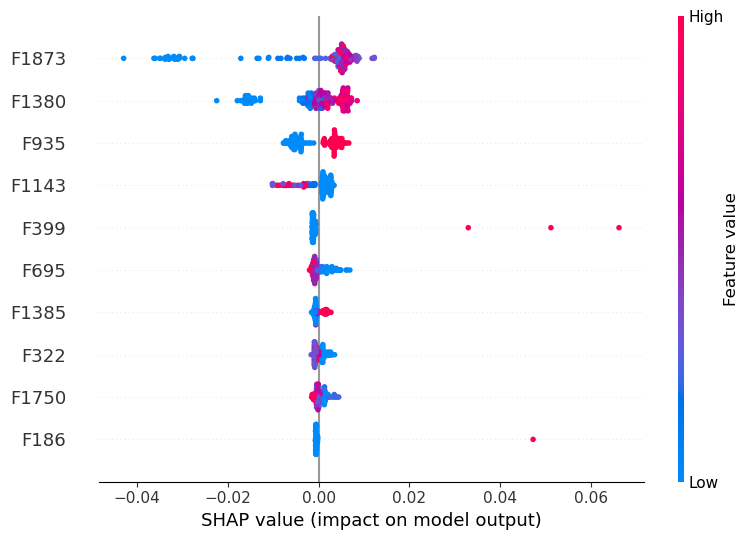

In [6]:
shap.summary_plot(shap_values, X_train_np, feature_names=[f'F{i}' for i in range(X_train_np.shape[1])],max_display=10)

In [ ]:
importances = np.abs(shap_values).mean(axis=0)  
top10_indices = np.argsort(importances)[::-1][:10]  
print("Top 10 important feature indices:", top10_indices)


Top 10 important feature indices: [1873 1380  935 1143  399  695 1385  322 1750  186]


Top 1 Bit 1873 found in molecule.


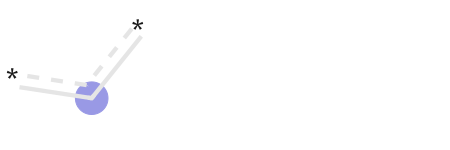

Top 2 Bit 1380 found in molecule.


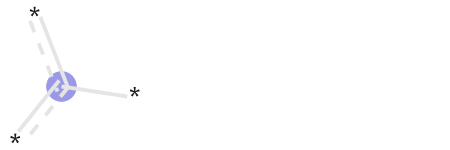

Top 3 Bit 935 found in molecule.


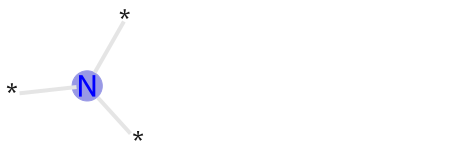

Top 4 Bit 1143 found in molecule.


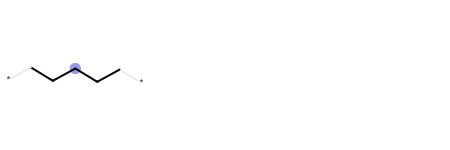

Top 5 Bit 399 found in molecule.


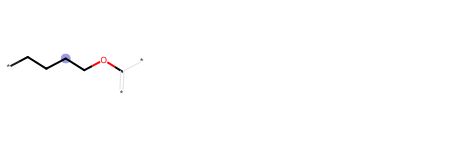

Top 6 Bit 695 found in molecule.


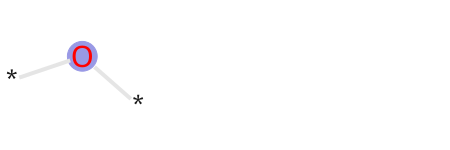

Top 7 Bit 1385 found in molecule.


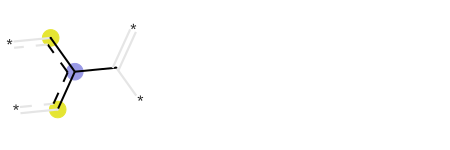

Top 8 Bit 322 found in molecule.


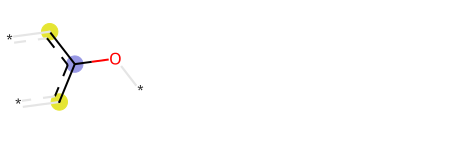

Top 9 Bit 1750 found in molecule.


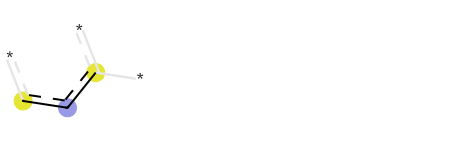

Top 10 Bit 186 found in molecule.


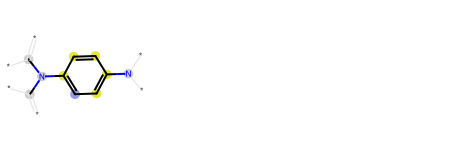

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from IPython.display import display

def find_molecule_with_bit(bit_idx, smiles_list):
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        info = {}
        AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048, bitInfo=info)
        if bit_idx in info:
            return mol, info
    return None, None


# top10_indices = [...]

for i, bit_idx in enumerate(top10_indices):
    mol, info = find_molecule_with_bit(bit_idx, data_ty['smiles'])
    
    if mol:
        print(f"Top {i+1} Bit {bit_idx} found in molecule.")
        
        img=Draw.DrawMorganBits([(mol, bit_idx, info)],useSVG=True)
        display(img)
        
    else:
        print(f"Bit {bit_idx} not found in dataset.")


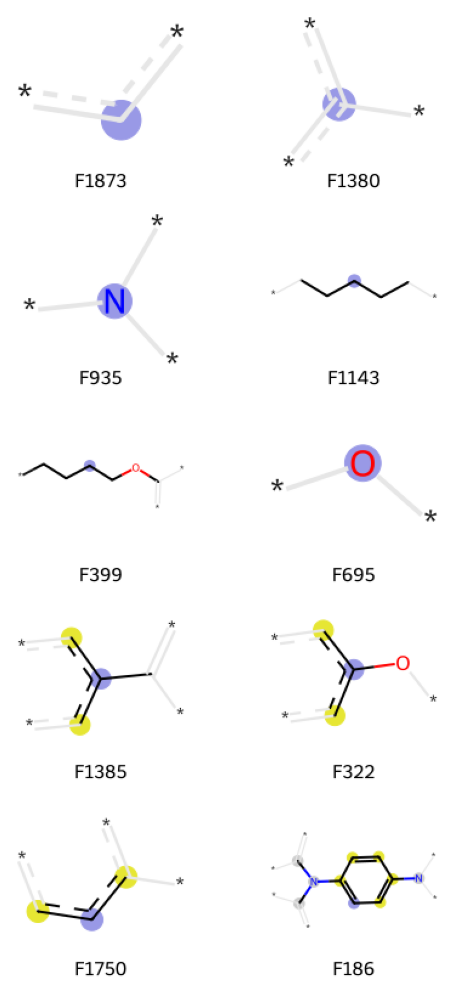

In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import matplotlib.pyplot as plt

def find_molecule_with_bit(bit_idx, smiles_list):
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        info = {}
        AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048, bitInfo=info)
        if bit_idx in info:
            return mol, info
    return None, None

fig, axes = plt.subplots(5, 2, figsize=(6, 10))

for ax, bit_idx in zip(axes.flatten(), top10_indices):
    mol, info = find_molecule_with_bit(bit_idx, data_ty['smiles'])

    if mol:
        img = Draw.DrawMorganBit(mol, bit_idx, info, legend=f'F{bit_idx}')
        ax.imshow(img)
        #ax.set_title(f'Bit {bit_idx}')
    else:
        #ax.text(0.5, 0.5, f'Bit {bit_idx}\nnot found', fontsize=14, ha='center')
        pass
        
    ax.axis('off')

plt.tight_layout()
#plt.show()
plt.savefig('top10_morgan_bits.jpg', dpi=500, bbox_inches='tight')


In [10]:
shap.initjs()

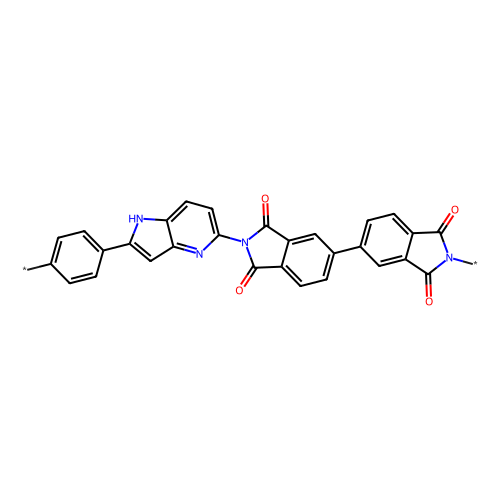

In [ ]:
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import Image
sample_idx = 50
sample_SMILES=data_ty.loc[index_train[sample_idx], 'smiles']
mol = Chem.MolFromSmiles(sample_SMILES)
drawer = rdMolDraw2D.MolDraw2DCairo(500, 500)  # 500x500 pixels
drawer.DrawMolecule(mol)
drawer.FinishDrawing()
png = drawer.GetDrawingText()
Image(data=png)

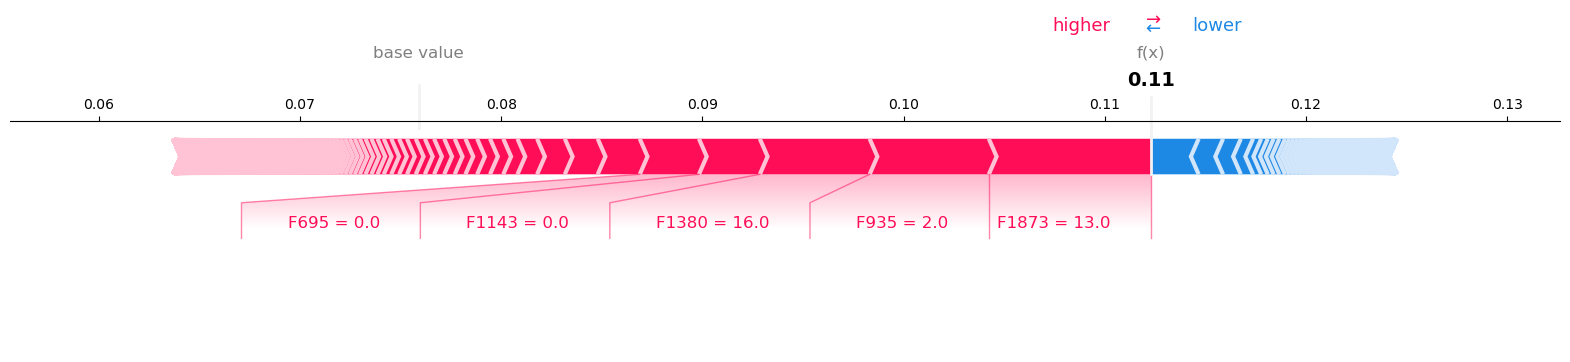

In [12]:
sample_idx = 50
X_sample = np.array(X_train_np)[sample_idx].reshape(1, -1)
shap_values_sample = explainer.shap_values(X_sample)
shap.force_plot(
    explainer.expected_value, 
    shap_values_sample,        
    X_sample, 
    feature_names=[f'F{i}' for i in range(X_sample.shape[1])],
    matplotlib=True
)

高亮原子编号: [9, 24, 3, 4, 6, 8, 10, 12, 15, 16, 19, 20, 22, 26, 29, 30, 34, 0, 1, 2, 5, 13, 14, 17, 18, 21, 28, 32, 33, 36, 37]


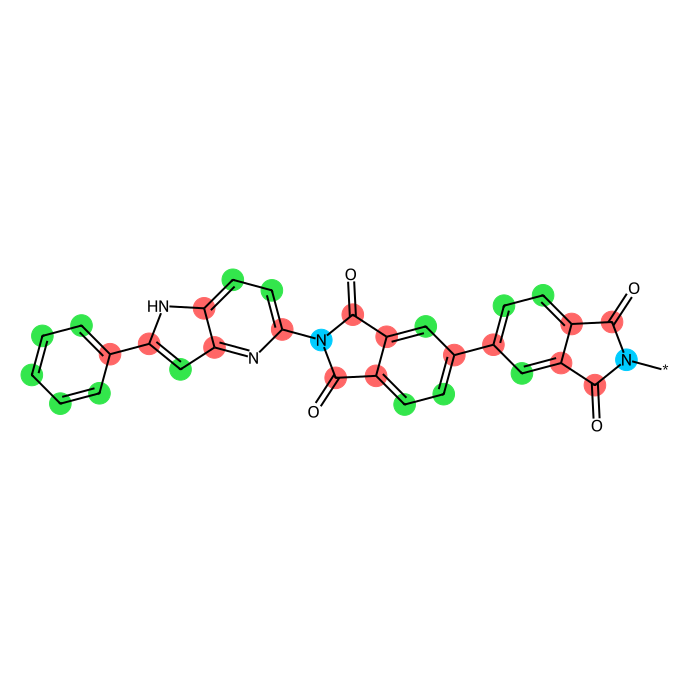

In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import Image

# SMILES
target_smiles = "c1ccc(c2cc3nc(N4C(=O)c5ccc(c6ccc7c(c6)C(=O)N(*)C7=O)cc5C4=O)ccc3[nH]2)cc1"
mol = Chem.MolFromSmiles(target_smiles)

# 计算 Morgan 指纹 & bitInfo
bitInfo = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048, bitInfo=bitInfo)

# 指定 bits 和颜色
highlight_bits = [935, 1380, 1873]
bit_colors = {
    935: (0.0, 0.8, 1.0),   # 青蓝色
    1380: (1.0, 0.4, 0.4),  # 红色
    1873: (0.2, 0.9, 0.3)   # 绿色
}

highlight_atoms = []
highlight_atom_colors = {}

# 只高亮中心原子
for bit in highlight_bits:
    if bit in bitInfo:
        atom_infos = bitInfo[bit]
        for atom_idx, radius in atom_infos:
            highlight_atoms.append(atom_idx)
            highlight_atom_colors[atom_idx] = bit_colors[bit]

print(f"高亮原子编号: {highlight_atoms}")

# 计算 2D 坐标
AllChem.Compute2DCoords(mol)

# 设置绘图
drawer = rdMolDraw2D.MolDraw2DCairo(700, 700)
options = drawer.drawOptions()
options.useBWAtomPalette()  # 其他原子黑白，突出高亮
options.highlightRadius = 0.4  # 高亮圆圈大小
options.addAtomIndices = False  # 显示原子编号可设 True

# 绘制
drawer.DrawMolecule(
    mol,
    highlightAtoms=highlight_atoms,
    highlightAtomColors=highlight_atom_colors,
    highlightBonds=[]  # 不高亮键
)
drawer.FinishDrawing()

# 显示
png = drawer.GetDrawingText()
Image(data=png)
